In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from utils import ffmpeg_load_audio, list_all_files
from multiprocessing import Pool
import numpy as np
from librosa.feature import rmse, spectral_centroid, spectral_rolloff, spectral_bandwidth, chroma_cqt

In [6]:
sr=44100
output_dir = 'input/28k'
%time samples = np.load(output_dir + '/samples.npy')

CPU times: user 768 µs, sys: 4.66 s, total: 4.66 s
Wall time: 6.95 s


In [21]:
def get_stats(y, sr, hop_length=256):
    results = {}
    S, phase = librosa.magphase(librosa.stft(y=y, n_fft=2048, hop_length=hop_length))
    env = np.array(rmse(S=S).reshape(-1))
    peak = env.argmax()
    cs = np.cumsum(env)
    cs /= cs.max()
    return {
        'peak': hop_length * peak,
        'percentiles': [
            hop_length * (np.searchsorted(cs, 0.1) - peak),
            hop_length * (np.searchsorted(cs, 0.5) - peak),
            hop_length * (np.searchsorted(cs, 0.9) - peak)
        ],
        'power': env.sum(),
        'centroid': spectral_centroid(S=S)[0,peak],
        'rolloff': spectral_rolloff(S=S)[0,peak],
        'bandwidth': spectral_bandwidth(S=S)[0,peak],
        'chroma': chroma_cqt(y=y, sr=sr, hop_length=hop_length, tuning=0)[:,peak]
    }

In [22]:
def get_stats_closure(y):
    return get_stats(y, sr)

In [25]:
p = Pool(4)
%time results = p.map(get_stats_closure, samples)

CPU times: user 5.61 s, sys: 9.02 s, total: 14.6 s
Wall time: 4min 56s


In [26]:
results[0]

{'bandwidth': 484.87361159983811,
 'centroid': 248.02390571094796,
 'chroma': array([ 1.        ,  0.63866742,  0.67089586,  0.62476084,  0.49453388,
         0.42044514,  0.22397193,  0.20567255,  0.20298337,  0.22876213,
         0.31082458,  0.97411156]),
 'peak': 512,
 'percentiles': [0, 5376, 16640],
 'power': 457.35565,
 'rolloff': 333.7646484375}

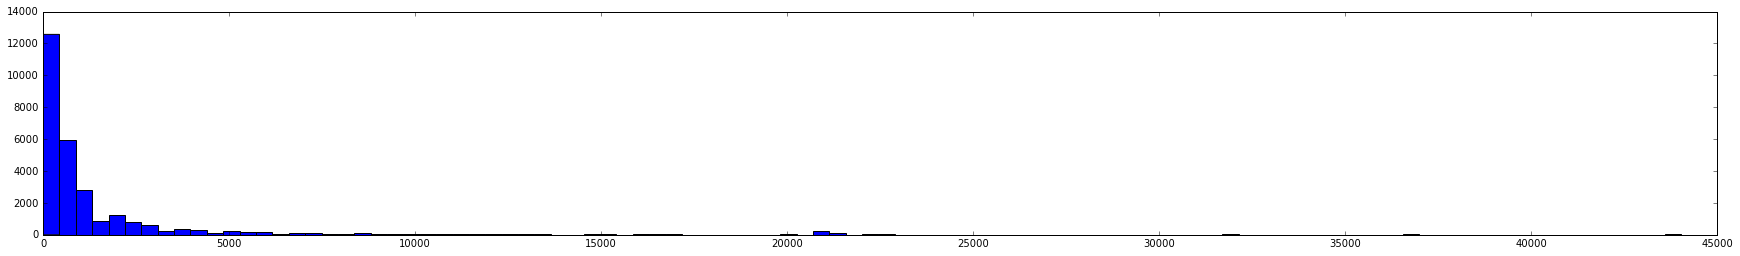

In [37]:
plt.figure(figsize=(30,4))
plt.hist([x['peak'] for x in results], bins=100)
plt.show()

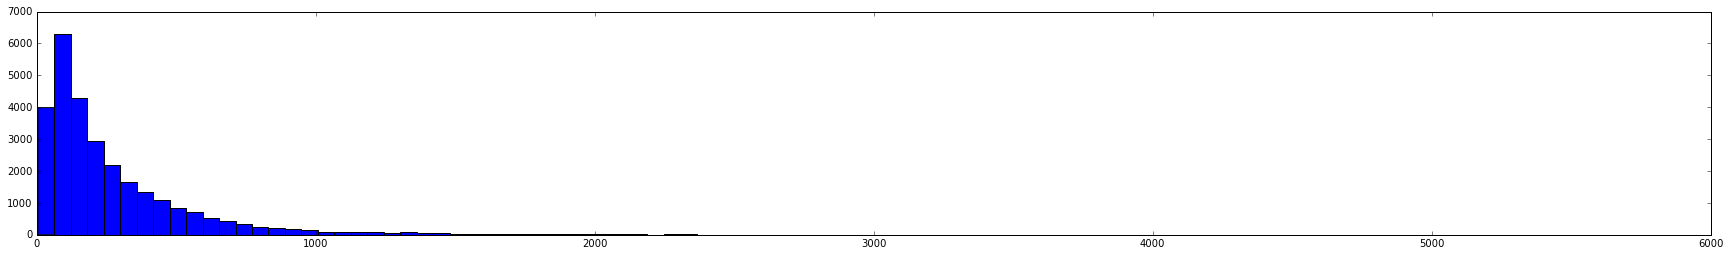

In [41]:
plt.figure(figsize=(30,4))
plt.hist([x['power'] for x in results], bins=100)
plt.show()

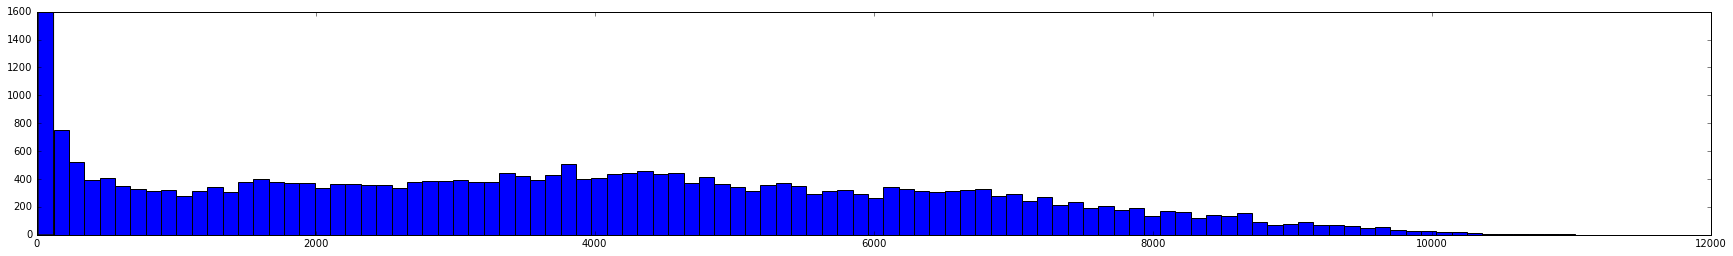

In [40]:
plt.figure(figsize=(30,4))
plt.hist([x['rolloff'] for x in results], bins=100)
plt.show()

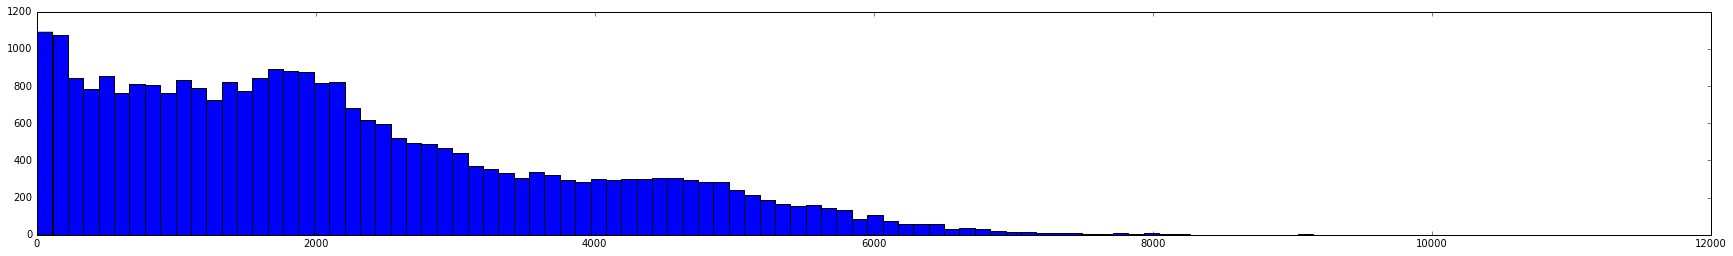

In [38]:
plt.figure(figsize=(30,4))
plt.hist([x['centroid'] for x in results], bins=100)
plt.show()

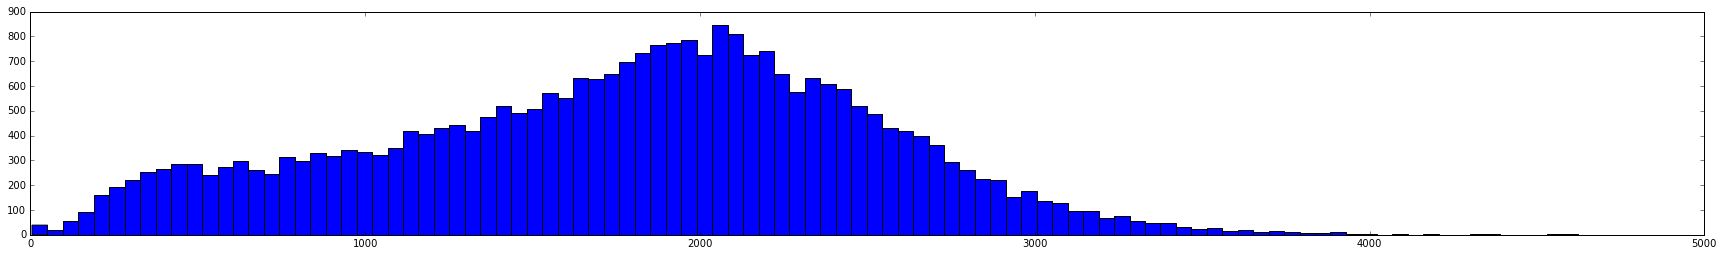

In [39]:
plt.figure(figsize=(30,4))
plt.hist([x['bandwidth'] for x in results], bins=100)
plt.show()

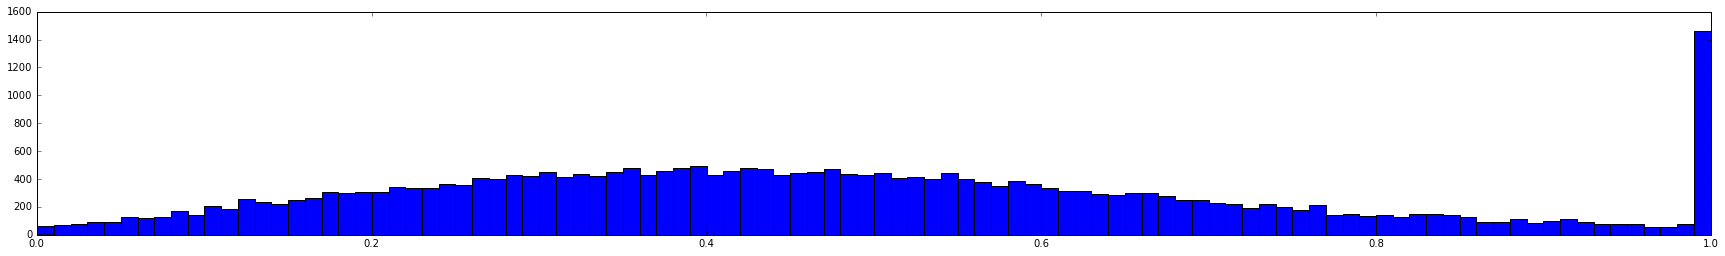

In [49]:
plt.figure(figsize=(30,4))
plt.hist([x['chroma'][10] for x in results], bins=100)
plt.show()

In [52]:
import cPickle as pickle
with open('results.pkl', 'w') as f:
    pickle.dump(results, f)